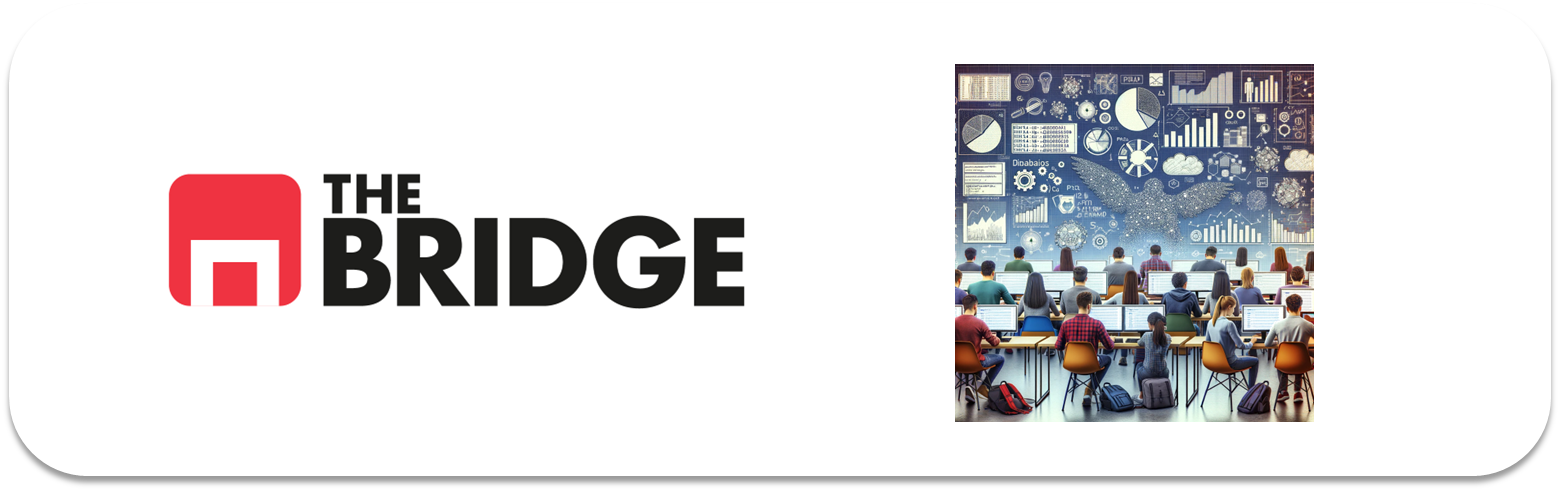

## PRACTICA OBLIGATORIA: **Clasificacion y Regresion Logistica**

* La práctica obligatoria de esta unidad consiste en modelar la supervivencia en el Titanic, por fin, además de una parte adicional multiclase. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Mejora características de impresión
from pprint import pprint

# Tratamiento de variables categóricas
from sklearn.preprocessing import OrdinalEncoder

# Tratamiento variables numéricas
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Separación df
from sklearn.model_selection import train_test_split

# Evaluación regresión lineal
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Evaluación regresión logística
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay


# Entrenamiento modelos
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression

from EDA_function_tools import *

from scipy.stats import skew, kurtosis
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

### Indicaciones

A continuación tienes las indicaciones para hacer el modelado. No necesariamente tienes que seguirlos al pie de la letra, porque a partir de ahora ya las práctica obligatorias dejarán de ser mayormente guiadas por ejercicios y serán más de libre desarrollo, aunque con objetivos específicos, claros y determinados. 

En concreto se pide hacer un modelo de regresión logística, evaluarlo contra un dataset de test reservado del original mostrando las métricas propias de los problemas de clasificación, la matriz de confusión y la curva ROC. Además se pide comparar las predicciones con los valores reales y al final adaptar el modelo a un problema multiclase.

Los pasos para guiar el trabajo:
1. Carga el dataset del Titanic. 
2. Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.
3. Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.
4. Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.
5. Construye las parejas X,y de train y test.
6. Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.
7. Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.
8. Trata las variables para que funcionen lo mejor posible en el modelo.
9. Construye un modelo de regresión logística.
10. EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.
11. Procesa el dataset de Test para que puedas usarlo en la evaluación 
12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.
13. EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.
14. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.  



## Funciones

In [2]:


def check_log_transformation_completa(df, feature_num):
    results = []
    
    for feature_name in feature_num:
        # Calcular asimetría y kurtosis
        skewness = skew(df[feature_name])
        kurt = kurtosis(df[feature_name])
        
        # Calcular IQR
        q75, q25 = np.percentile(df[feature_name], [75 ,25])
        iqr = q75 - q25
        
        # Calcular la prueba de Breusch-Pagan para heterocedasticidad
        X = df[feature_name]
        y = df['survived']  # Variable de respuesta
        X = sm.add_constant(X)  # Añadir intercepto

        # Ajustar el modelo de regresión lineal
        model = sm.OLS(y, X).fit()

        # Calcular los residuos
        residuals = model.resid

        # Calcular la prueba de Breusch-Pagan
        lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(residuals, X)
        
        # Determinar si se recomienda la transformación logarítmica
        log_transform = False
        reason = []
        
        # Criterios para la transformación logarítmica
        skew_threshold = 0.5  # Umbral para la asimetría
        kurt_threshold = 3.0  # Umbral para la kurtosis
        lm_p_value_threshold = 0.05  # Umbral para el valor p de la prueba de Breusch-Pagan
        iqr_threshold = 1.5  # Umbral para el IQR
        
        if abs(skewness) > skew_threshold:
            log_transform = True
            reason.append('skewness')
        
        if kurt > kurt_threshold:
            log_transform = True
            reason.append('kurtosis')
        
        if lm_p_value < lm_p_value_threshold:
            log_transform = True
            reason.append('breusch_pagan_lm_p_value')
            
        if iqr > iqr_threshold:
            log_transform = True
            reason.append('iqr')
        
        # Almacenar los resultados
        result = {
            'Variable': feature_name,
            'Log Transformation': log_transform,
            'Reason': reason,
            'Skewness': skewness,
            'Kurtosis': kurt,
            'IQR': iqr,
            'Breusch-Pagan LM': lm,
            'Breusch-Pagan LM p-value': lm_p_value,
            'Breusch-Pagan F-value': fvalue,
            'Breusch-Pagan F p-value': f_p_value
        }
        
        results.append(result)
    
    # Convertir la lista de resultados en un DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df


def plot_categorical_comparison(df, cat_vars, target_var):
    # Configuración del tamaño del gráfico
    plt.figure(figsize=(12, 8))
    
    # Iterar sobre cada variable categórica
    for i, cat_var in enumerate(cat_vars, start=1):
        plt.subplot(1, len(cat_vars), i)
        
        # Calcular la proporción de 1s en la variable objetivo para cada categoría
        prop_1 = df.groupby(cat_var)[target_var].mean() * 100  # Convertir a porcentaje
        
        # Crear el gráfico de barras horizontal
        sns.barplot(x=prop_1.values, y=prop_1.index)
        
        # Añadir título
        plt.title(f'Proporción supervivientes con {cat_var}')
        
        # Añadir etiquetas a las barras
        for index, value in enumerate(prop_1):
            plt.text(value, index, f'{value:.2f}%', va='center')
        
    # Ajustar el diseño de los subplots
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()

## 1. Carga dataset

In [3]:
df = pd.read_csv("./data/titanic.csv")

In [4]:
df.head(8)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [6]:
lista_columnas = df.columns.tolist()
lista_columnas

['survived',
 'pclass',
 'sex',
 'age',
 'sibsp',
 'parch',
 'fare',
 'embarked',
 'class',
 'who',
 'adult_male',
 'deck',
 'embark_town',
 'alive',
 'alone']

| Columna      | Descripción                                                                 |Eliminar|
|--------------|-----------------------------------------------------------------------------|--|
| survived     | Indica si el pasajero sobrevivió (1) o no (0).                              ||
| pclass       | Clase de boleto del pasajero (1 = Primera clase, 2 = Segunda clase, 3 = Tercera clase). ||
| sex          | Género del pasajero (male = masculino, female = femenino).                   ||
| age          | Edad del pasajero.                                                          ||
| sibsp        | Número de hermanos/cónyuges a bordo.                                       ||
| parch        | Número de padres/hijos a bordo.                                            ||
| fare         | Tarifa del pasaje.                                                          ||
| embarked     | Puerto de embarque (C = Cherbourg, Q = Queenstown, S = Southampton).        ||
| class        | Clase de boleto del pasajero (igual que pclass pero en formato de texto).   | Ya tengo columna pclass|
| who          | Indica si el pasajero es un hombre, una mujer o un niño (hombre, mujer, niño). ||
| adult_male   | Indica si el pasajero es adulto y masculino (True) o no (False).            ||
| deck         | Cubierta en la que se encontraba el pasajero.                               | Muchos nulos|
| embark_town  | Puerto de embarque (igual que embarked pero en formato de texto).           |Ya tengo embarked| 
| alive        | Indica si el pasajero sobrevivió (yes) o no (no).                           | Ya tengo columna Survived|
| alone        | Indica si el pasajero viajaba solo (True) o no (False).                     ||


## 2. Eliminación variables
Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.

In [7]:
df.drop(columns=['class','deck','alive','embark_town'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    int64  
 1   pclass      891 non-null    int64  
 2   sex         891 non-null    object 
 3   age         714 non-null    float64
 4   sibsp       891 non-null    int64  
 5   parch       891 non-null    int64  
 6   fare        891 non-null    float64
 7   embarked    889 non-null    object 
 8   who         891 non-null    object 
 9   adult_male  891 non-null    bool   
 10  alone       891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(3)
memory usage: 64.5+ KB


## 3. Variable target
Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.

La variable target será `survived`

c:\Users\Alfonso\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


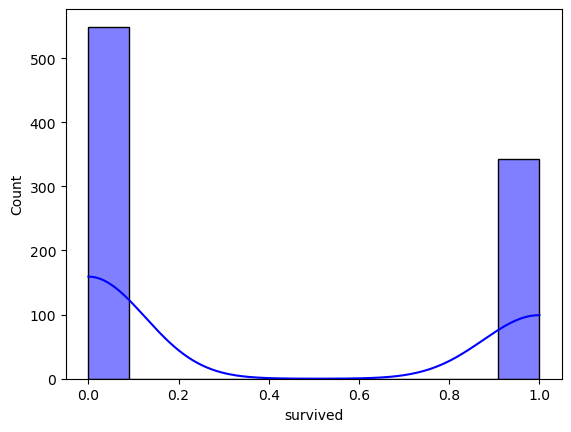

In [8]:
sns.histplot(df['survived'], color='Blue', kde = True)
plt.show();

In [9]:
df.survived.value_counts(normalize=True).round(2)

survived
0    0.62
1    0.38
Name: proportion, dtype: float64

Tenemos una mayoría de personas que no sobrevivieron. Esto puede afectar al modelo. Veremos...

## 5. Limpieza y modelado datos (hay que hacerlo antes de la separación)
Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.

In [10]:
df.groupby('who')['age'].median()

who
child     5.0
man      30.0
woman    30.0
Name: age, dtype: float64

In [11]:
df['med_age']= df.groupby('who')['age'].transform('mean')
df['age'] = df['age'].fillna(df['med_age'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    int64  
 1   pclass      891 non-null    int64  
 2   sex         891 non-null    object 
 3   age         891 non-null    float64
 4   sibsp       891 non-null    int64  
 5   parch       891 non-null    int64  
 6   fare        891 non-null    float64
 7   embarked    889 non-null    object 
 8   who         891 non-null    object 
 9   adult_male  891 non-null    bool   
 10  alone       891 non-null    bool   
 11  med_age     891 non-null    float64
dtypes: bool(2), float64(3), int64(4), object(3)
memory usage: 71.5+ KB


In [12]:
df.embarked.mode()

0    S
Name: embarked, dtype: object

In [13]:
df['embarked']=df['embarked'].fillna(df['embarked'].mode().iloc[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    int64  
 1   pclass      891 non-null    int64  
 2   sex         891 non-null    object 
 3   age         891 non-null    float64
 4   sibsp       891 non-null    int64  
 5   parch       891 non-null    int64  
 6   fare        891 non-null    float64
 7   embarked    891 non-null    object 
 8   who         891 non-null    object 
 9   adult_male  891 non-null    bool   
 10  alone       891 non-null    bool   
 11  med_age     891 non-null    float64
dtypes: bool(2), float64(3), int64(4), object(3)
memory usage: 71.5+ KB


## 4. Separación datos, parejas X e y
Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.
Construye las parejas X,y de train y test.

In [14]:

train_set, test_set = train_test_split(df, test_size=0.30, random_state=42,stratify=df['embarked'] )

## 6. Mini EDA y features
Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.

### 6.1 Univariable

In [15]:
features_num = train_set.select_dtypes(include=('int','float')).columns.tolist()
features_cat = train_set.select_dtypes(include=('object')).columns.tolist()
print('var_num:',features_num)
print('var_cat:',features_cat)

var_num: ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare', 'med_age']
var_cat: ['sex', 'embarked', 'who']


#### Categóricas

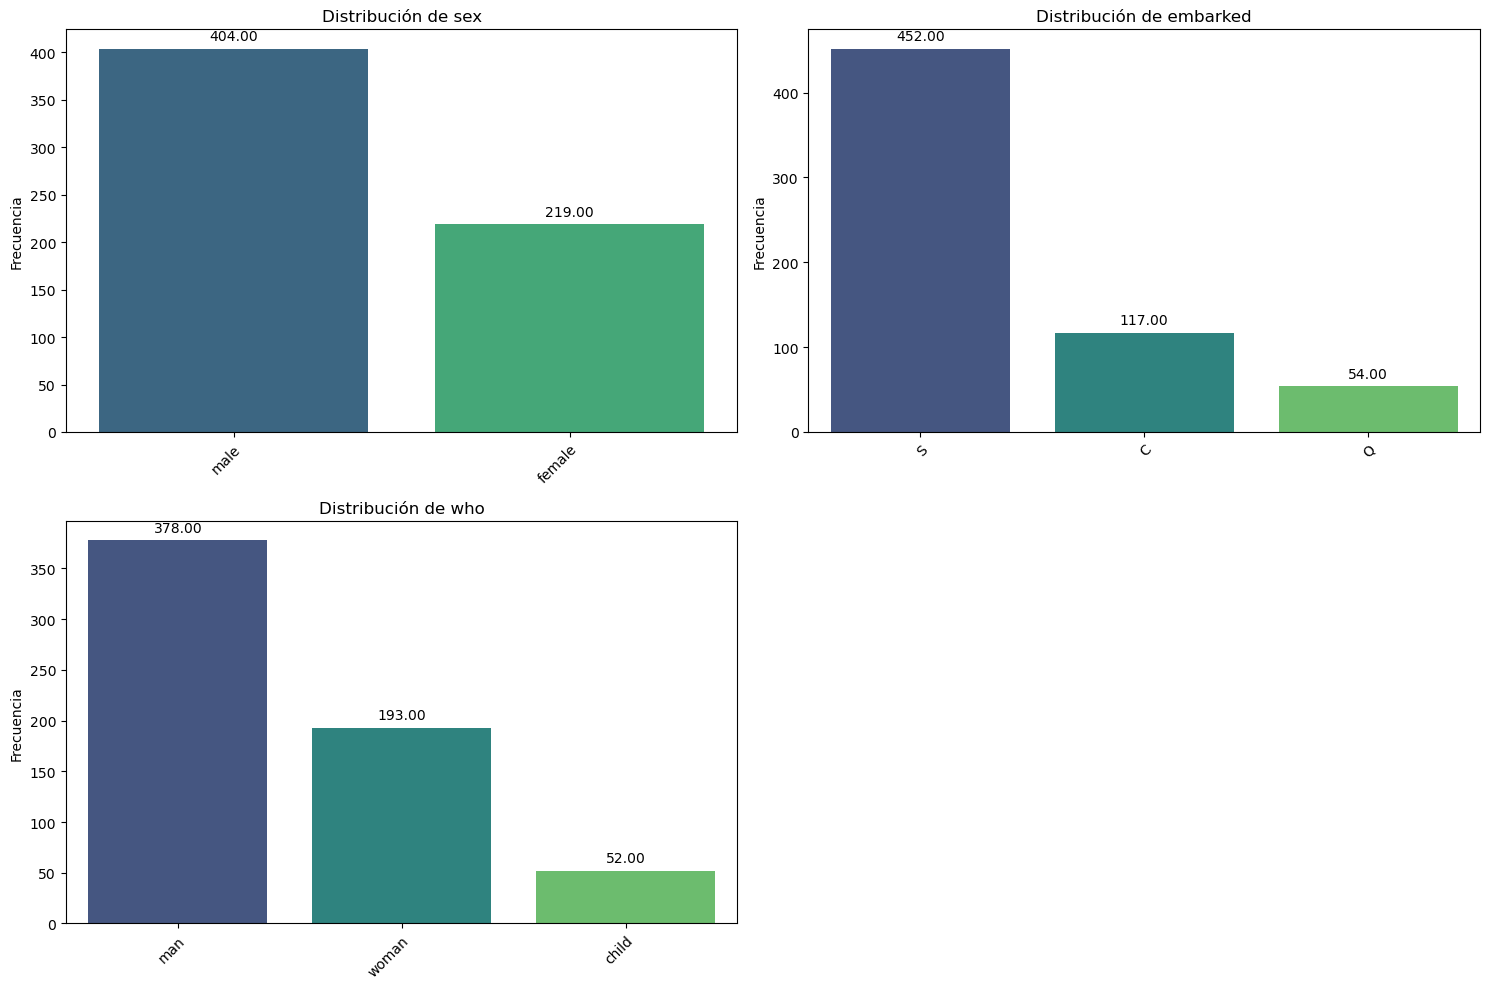

In [16]:
pinta_distribucion_categoricas_cgpt1(train_set,features_cat,mostrar_valores=True)

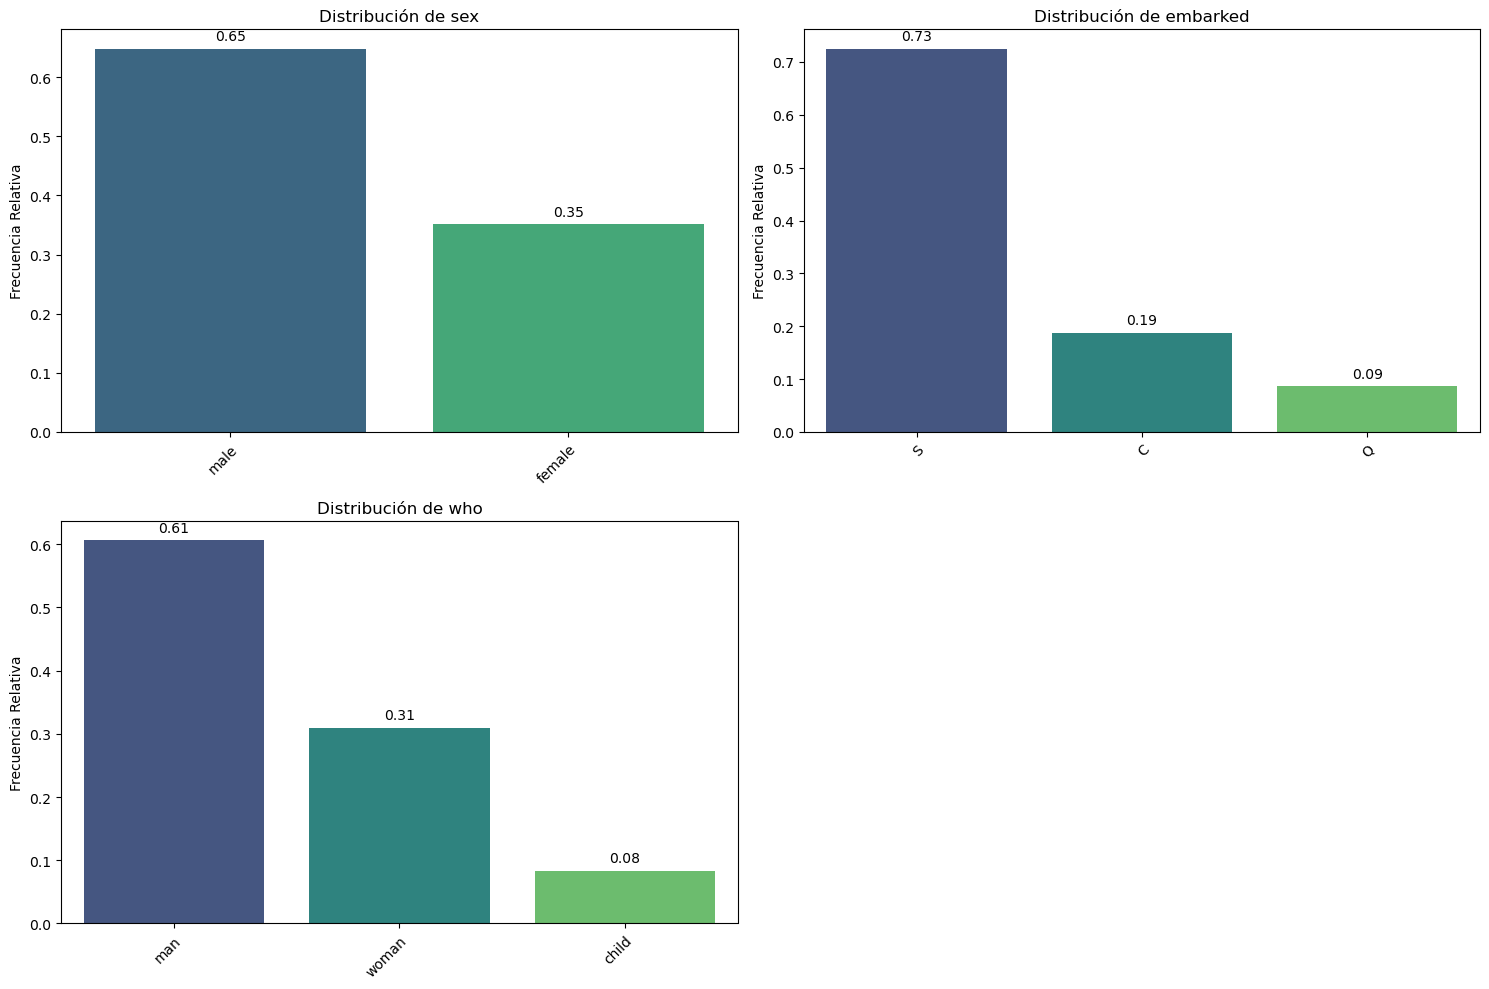

In [17]:
pinta_distribucion_categoricas_cgpt1(train_set,features_cat,mostrar_valores=True,relativa=True)

#### Numéricas

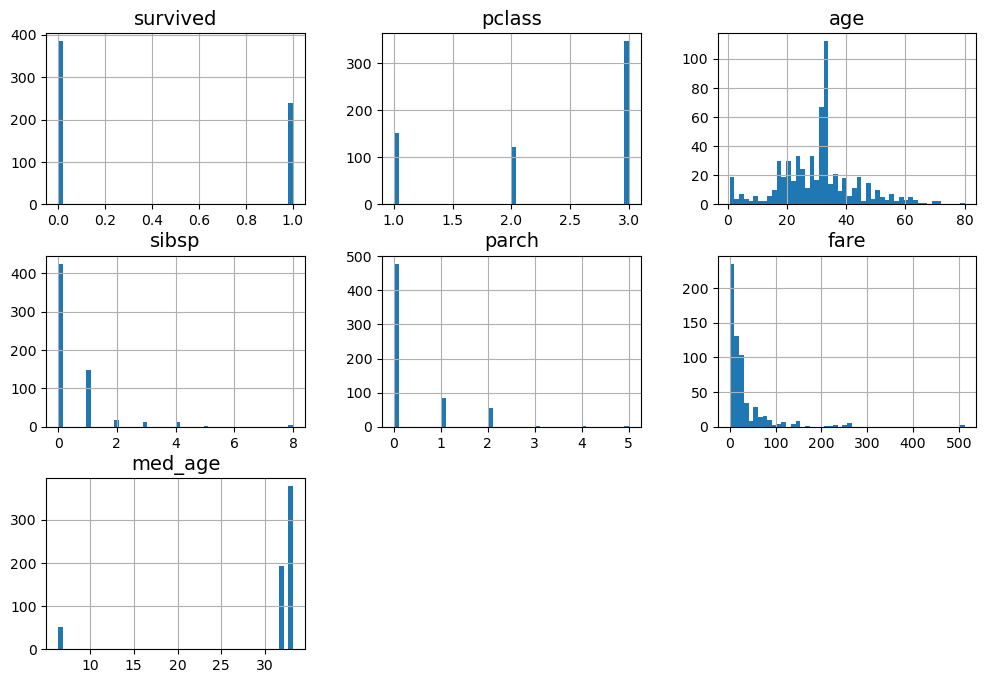

In [18]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

train_set.hist(bins=50, figsize=(12, 8))

plt.show()

In [19]:
check_log_transformation_completa(train_set,features_num)

,Variable,Log Transformation,Reason,Skewness,Kurtosis,IQR,Breusch-Pagan LM,Breusch-Pagan LM p-value,Breusch-Pagan F-value,Breusch-Pagan F p-value
0,survived,True,[breusch_pagan_lm_p_value],0.478634,-1.770910,1.000000,623.000000,1.664449e-137,1.010257e+33,0.000000
1,pclass,True,"[skewness, breusch_pagan_lm_p_value]",-0.637693,-1.285848,1.000000,9.006401,2.690357e-03,9.109175e+00,0.002648
2,age,True,[iqr],0.262768,0.869627,13.000000,0.612964,4.336740e-01,6.115980e-01,0.434485
3,sibsp,True,"[skewness, kurtosis, breusch_pagan_lm_p_value]",3.817015,18.857702,1.000000,5.790069,1.611696e-02,5.825624e+00,0.016083
4,parch,True,"[skewness, kurtosis, breusch_pagan_lm_p_value]",2.428636,7.208157,0.000000,6.087457,1.361449e-02,6.127790e+00,0.013573
5,fare,True,"[skewness, kurtosis, breusch_pagan_lm_p_value,...",4.964705,33.767598,22.604200,5.006985,2.524523e-02,5.031348e+00,0.025244
6,med_age,True,"[skewness, kurtosis, breusch_pagan_lm_p_value]",-2.983725,6.968681,1.173123,4.405171,3.583012e-02,4.422299e+00,0.035874


In [20]:
check_log_transformation_completa(train_set,features_num)

,Variable,Log Transformation,Reason,Skewness,Kurtosis,IQR,Breusch-Pagan LM,Breusch-Pagan LM p-value,Breusch-Pagan F-value,Breusch-Pagan F p-value
0,survived,True,[breusch_pagan_lm_p_value],0.478634,-1.770910,1.000000,623.000000,1.664449e-137,1.010257e+33,0.000000
1,pclass,True,"[skewness, breusch_pagan_lm_p_value]",-0.637693,-1.285848,1.000000,9.006401,2.690357e-03,9.109175e+00,0.002648
2,age,True,[iqr],0.262768,0.869627,13.000000,0.612964,4.336740e-01,6.115980e-01,0.434485
3,sibsp,True,"[skewness, kurtosis, breusch_pagan_lm_p_value]",3.817015,18.857702,1.000000,5.790069,1.611696e-02,5.825624e+00,0.016083
4,parch,True,"[skewness, kurtosis, breusch_pagan_lm_p_value]",2.428636,7.208157,0.000000,6.087457,1.361449e-02,6.127790e+00,0.013573
5,fare,True,"[skewness, kurtosis, breusch_pagan_lm_p_value,...",4.964705,33.767598,22.604200,5.006985,2.524523e-02,5.031348e+00,0.025244
6,med_age,True,"[skewness, kurtosis, breusch_pagan_lm_p_value]",-2.983725,6.968681,1.173123,4.405171,3.583012e-02,4.422299e+00,0.035874


In [21]:
train_set.describe().round(2)

,survived,pclass,age,sibsp,parch,fare,med_age
count,623.00,623.00,623.00,623.00,623.00,623.00,623.00
mean,0.38,2.31,30.60,0.53,0.36,32.73,30.57
std,0.49,0.84,12.97,1.13,0.74,53.48,7.33
min,0.00,1.00,0.75,0.00,0.00,0.00,6.37
25%,0.00,2.00,22.00,0.00,0.00,7.90,32.00
50%,0.00,3.00,32.00,0.00,0.00,14.46,33.17
75%,1.00,3.00,35.00,1.00,0.00,30.50,33.17
max,1.00,3.00,80.00,8.00,5.00,512.33,33.17


### 6.2 Bivariable

#### Categórica

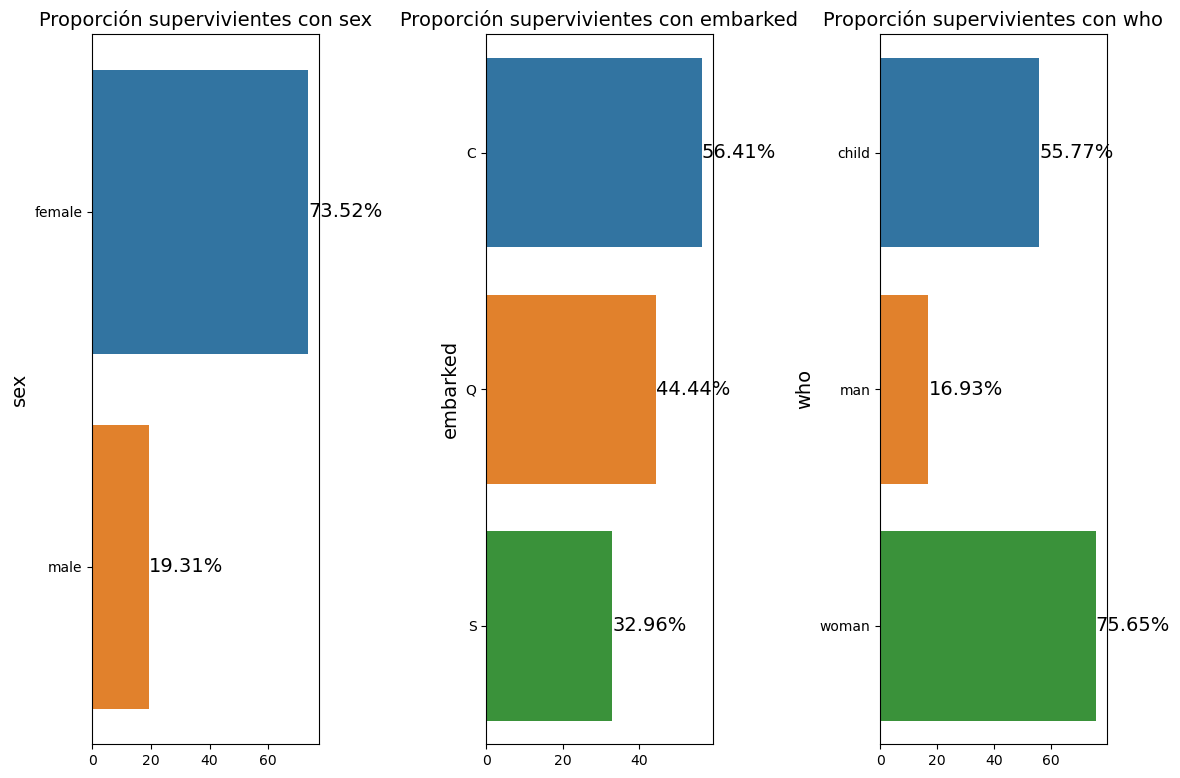

In [22]:
plot_categorical_comparison(train_set,features_cat,'survived')

La variable `sex` y la variable `who` contienen porcentajes de supervivientes muy diferentes.   
DUDA:  
Influirá???

#### Numérica

In [23]:
correlation_matrix = train_set[features_num].corr().round(3)
print(correlation_matrix)


          survived  pclass    age  sibsp  parch   fare  med_age
survived     1.000  -0.332 -0.065 -0.036  0.062  0.259   -0.147
pclass      -0.332   1.000 -0.320  0.071  0.007 -0.530   -0.110
age         -0.065  -0.320  1.000 -0.222 -0.221  0.080    0.580
sibsp       -0.036   0.071 -0.222  1.000  0.465  0.162   -0.367
parch        0.062   0.007 -0.221  0.465  1.000  0.234   -0.417
fare         0.259  -0.530  0.080  0.162  0.234  1.000   -0.010
med_age     -0.147  -0.110  0.580 -0.367 -0.417 -0.010    1.000


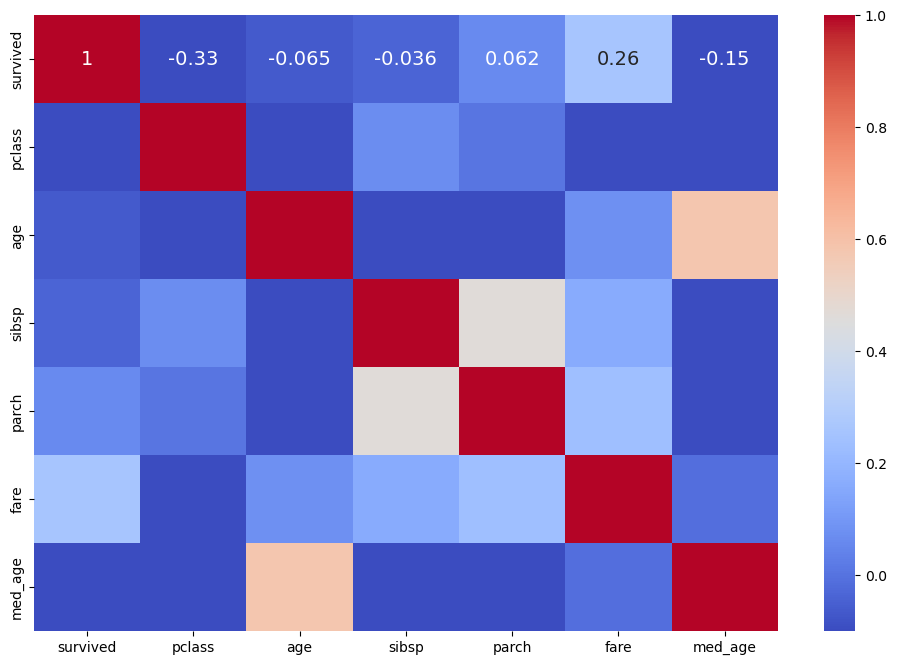

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix,
           vmin=-0.1,
           vmax=1,
           cmap='coolwarm',
           annot=True);

Correlaciones con la variable target:
- La variable `pclass` y `survived` tienen un correlación negativa de 0.33; lo que significa que a menor clase, mayor supervivencia (la gente de primera sobrevivió más)
- La variable `fare` y `survived` tienen una correlación positiva de 0.26; lo que significa que a mayor importe del billete mayor supervivencia.

Correlaciones entre variables:
- Hay una correlación negativa de 0.53 entre `pclass` y `fare`; lo que indica que a menor clase, mayor coste del billete (los de primera clase, pagan más)
- Hay una correlación negativa de 0.32 entre `pclass` y `age`, lo que significa que a menor importe de la clase, mayor edad.
- Hay una correlación positiva de 0.46 entre `parch`y `sibsp`, obvio dado que se trata de familiares.
- Hay una correlación positiva de 0.58 entre `age` y `med_age`, algo obvio dado que `med_age` se ha obtenido a partir de `age`, si bien, `med_age` muestra más correlación (negativa) con `sibsp` y `parch` que la propia `age`.

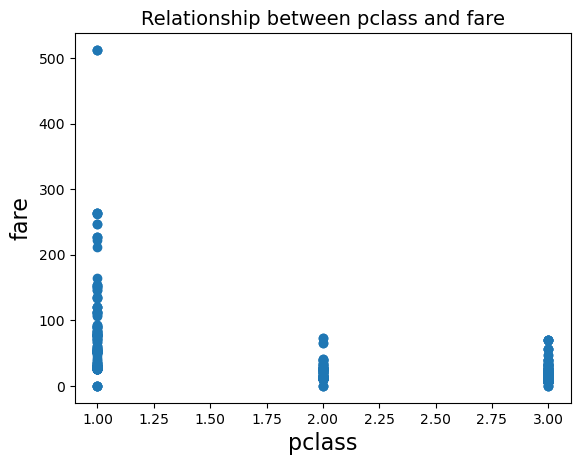

In [25]:
# Comprobación entre `pclass` y `fare`
variable_1 = 'pclass'
variable_2 = 'fare'

plt.scatter(train_set[variable_1], train_set[variable_2])
plt.xlabel(variable_1, fontsize=16)
plt.ylabel(variable_2, fontsize=16)
plt.title(f"Relationship between {variable_1} and {variable_2}", fontsize=14)
plt.show()


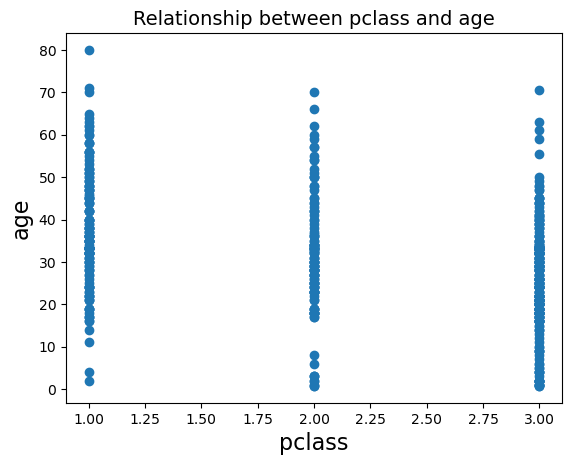

In [26]:
# Comprobación entre `pclass` y `age`
variable_1 = 'pclass'
variable_2 = 'age'

plt.scatter(train_set[variable_1], train_set[variable_2])
plt.xlabel(variable_1, fontsize=16)
plt.ylabel(variable_2, fontsize=16)
plt.title(f"Relationship between {variable_1} and {variable_2}", fontsize=14)
plt.show()


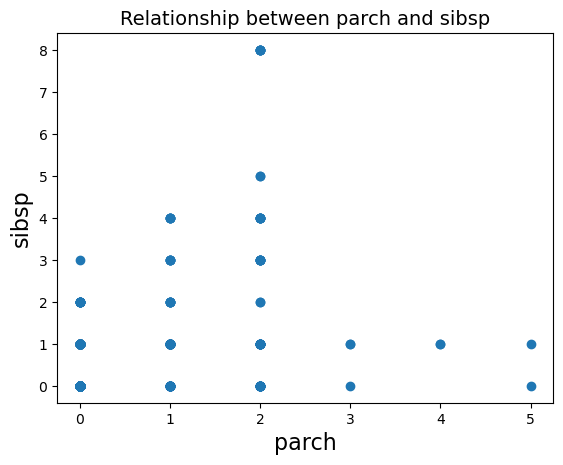

In [27]:
# Comprobación entre entre `parch`y `sibsp`
variable_1 = 'parch'
variable_2 = 'sibsp'

plt.scatter(train_set[variable_1], train_set[variable_2])
plt.xlabel(variable_1, fontsize=16)
plt.ylabel(variable_2, fontsize=16)
plt.title(f"Relationship between {variable_1} and {variable_2}", fontsize=14)
plt.show()


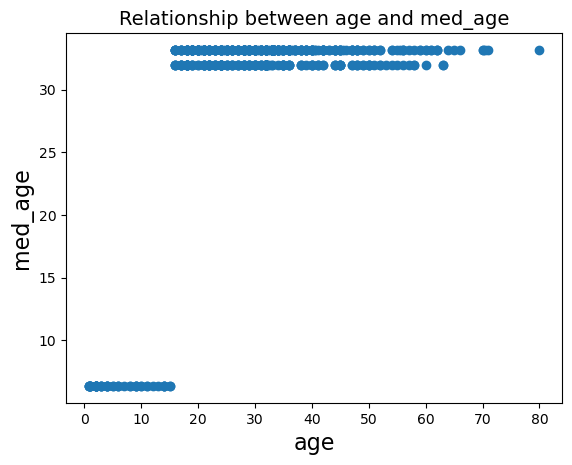

In [28]:
# Comprobación entre `age` y `med_age`
variable_1 = 'age'
variable_2 = 'med_age'

plt.scatter(train_set[variable_1], train_set[variable_2])
plt.xlabel(variable_1, fontsize=16)
plt.ylabel(variable_2, fontsize=16)
plt.title(f"Relationship between {variable_1} and {variable_2}", fontsize=14)
plt.show()


No sé cómo quedará mejor el modelo, si:
- incluyendo a todas las variables
- eliminando las que tienen una correlación más baja
- eliminando las que tienen una correlación más grande entre ellas

DUDA:  
¿Habría que probar con las tres posbilidades? ¿Habría alguna más?

De primeras voy a meter todas las variables. Si da tiempo, probaré otras posibilidades

## 7. Tratamiento variables
Trata las variables para que funcionen lo mejor posible en el modelo.

### Numéricas

Se va a ralizar una tranformación logarítmica a todas las variables numéricas (excepto a la target) y posteriormente un min-max-scaling para tener todos los datos entre 0 y 1.
- Al parecer para la regresión logística es mejor tener los datos entre 0 y 1 (¿porque así está la variable target y las variables categóricas????).  
DUDA:
¿ESto es correcto?

In [29]:
features_log = features_num.copy()
features_log.remove('survived')

In [30]:
print(features_log)

['pclass', 'age', 'sibsp', 'parch', 'fare', 'med_age']


In [31]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))

#for col in features_log:
    # Se crea una nueva columna en el df con el sufijo "log_" más el nombre de la variable.
 #   train_set[f"log_{col}"] = train_set[col].apply(np.log)
    # Se las aplica el tratamiento correspondiente (en este caso Min-Max-Scaling) sobre la variable original del df.
  #  train_set[col] = min_max_scaler.fit_transform(train_set[[f"log_{col}"]])

#train_set.describe()

DUDA:   
¿Porqué pasa esto?(arriba).   
Si se suma una cantidad muy pequeña (ChatGPT), no hay problema (o al menos saca un resultado)

In [32]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

epsilon = 1e-10  # Cantidad muy pequeña

for col in features_log:
    # Aplica el logaritmo a los valores sumando una cantidad muy pequeña
    train_set[f"log_{col}"] = train_set[col].apply(lambda x: np.log(x + epsilon))
    # Escala la columna logarítmica
    train_set[f"log_{col}"] = min_max_scaler.fit_transform(train_set[[f"log_{col}"]])

train_set.describe()

,survived,pclass,age,sibsp,parch,fare,med_age,log_pclass,log_age,log_sibsp,log_parch,log_fare,log_med_age
count,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000
mean,0.383628,2.311396,30.603147,0.528090,0.356340,32.731152,30.572481,0.681548,0.761239,0.296743,0.222174,0.871604,0.909774
std,0.486660,0.840675,12.974431,1.126456,0.735954,53.478277,7.329035,0.413935,0.151130,0.433676,0.401984,0.121214,0.274946
min,0.000000,1.000000,0.750000,0.000000,0.000000,0.000000,6.369518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800,32.000000,0.630930,0.723541,0.000000,0.000000,0.857418,0.978182
50%,0.000000,3.000000,32.000000,0.000000,0.000000,14.458300,33.173123,1.000000,0.803780,0.000000,0.000000,0.878089,1.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,30.500000,33.173123,1.000000,0.822970,0.917171,0.000000,0.903596,1.000000
max,1.000000,3.000000,80.000000,8.000000,5.000000,512.329200,33.173123,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


DUDA:
El rango es (-1,1) o es (0,1)??? o puede ser ambos dependiendo del contexto????

### Categóricas

Voy a utlizar el One-Hot Encoding, para tener todas las variables con 0 y 1 (o en este rango)

In [33]:
features_cat

['sex', 'embarked', 'who']

In [34]:
train_set = pd.get_dummies(train_set,columns=features_cat, dtype = int)

In [35]:
train_set.columns

Index(['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare', 'adult_male',
       'alone', 'med_age', 'log_pclass', 'log_age', 'log_sibsp', 'log_parch',
       'log_fare', 'log_med_age', 'sex_female', 'sex_male', 'embarked_C',
       'embarked_Q', 'embarked_S', 'who_child', 'who_man', 'who_woman'],
      dtype='object')

## 8. Modelo regresión logística
Construye un modelo de regresión logística.
EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.

### Con todas las variables

In [36]:
columnas_eliminar = ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare', 'adult_male', 'alone', 'med_age']

X_train = train_set.drop(columnas_eliminar,axis = 1)
y_train = train_set['survived']
print(X_train.shape)
print(y_train.shape)

(623, 14)
(623,)


In [37]:
log_reg = LogisticRegression(max_iter = 5000)

In [38]:
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [39]:
print(log_reg.coef_)
print(log_reg.intercept_)
print(log_reg.classes_)

[[-1.89897391 -1.02851291 -0.37087631 -0.40694413  0.69528412 -0.36881315
   0.1922015  -0.19200019  0.19314215  0.18251255 -0.37545339  0.34636325
  -1.38435971  1.03819776]]
[2.13259326]
[0 1]


In [40]:
intercept = log_reg.intercept_
coefs = log_reg.coef_.ravel()

features = pd.DataFrame(coefs, X_train.columns, columns=['coefficient']).copy()
features['coefficient'] = np.abs(features['coefficient'])

features.sort_values('coefficient', ascending=False).head()

,coefficient
log_pclass,1.898974
who_man,1.384360
who_woman,1.038198
log_age,1.028513
log_fare,0.695284


### Sin variables con correlación más baja

In [41]:
columnas_eliminar = ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare', 'adult_male',
       'alone', 'med_age', 'log_age', 'log_sibsp', 'log_parch' ]

X_train_sv = train_set.drop(columnas_eliminar,axis = 1)
y_train_sv = train_set['survived']
print(X_train_sv.shape)
print(y_train_sv.shape)

(623, 11)
(623,)


In [42]:
#log_reg.fit(X_train_sv, y_train_sv)

### Sin variables que correlacionana entre sí

- `pclass` correlacionaba con `fare` y `age`; así que cojo esta solo
- `pchar` correlacionaba con `sibsp' 
- `med_age` correlacionaba con `age` 

In [43]:
columnas_eliminar = ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare', 'adult_male',
       'alone', 'med_age', 'log_age', 'log_sibsp', 'log_fare']

X_train_sc = train_set.drop(columnas_eliminar,axis = 1)
y_train_sc = train_set['survived']
print(X_train_sc.shape)
print(y_train_sc.shape)

(623, 11)
(623,)


In [44]:
#log_reg.fit(X_train_sc, y_train_sc)

## 9. Procesamiento dataset TEST 
Procesa el dataset de Test para que puedas usarlo en la evaluación 

- Al final los nulos se trataron con el df total, dado que no se podía hacer la separación entre Train y Test con nulos
- Habría que hacer tan solo las transformaciones para las variables numéricas y las categóricas y posteriormente el X e y

In [45]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268 entries, 544 to 170
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    268 non-null    int64  
 1   pclass      268 non-null    int64  
 2   sex         268 non-null    object 
 3   age         268 non-null    float64
 4   sibsp       268 non-null    int64  
 5   parch       268 non-null    int64  
 6   fare        268 non-null    float64
 7   embarked    268 non-null    object 
 8   who         268 non-null    object 
 9   adult_male  268 non-null    bool   
 10  alone       268 non-null    bool   
 11  med_age     268 non-null    float64
dtypes: bool(2), float64(3), int64(4), object(3)
memory usage: 23.6+ KB


#### Transformación numéricas_test

In [46]:
epsilon = 1e-10  # Cantidad muy pequeña

for col in features_log:
    # Aplica el logaritmo a los valores sumando una cantidad muy pequeña
    test_set[f"log_{col}"] = test_set[col].apply(lambda x: np.log(x + epsilon))
    # Escala la columna logarítmica
    test_set[f"log_{col}"] = min_max_scaler.fit_transform(test_set[[f"log_{col}"]])

test_set.describe()

,survived,pclass,age,sibsp,parch,fare,med_age,log_pclass,log_age,log_sibsp,log_parch,log_fare,log_med_age
count,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000
mean,0.384328,2.302239,29.659988,0.511194,0.440299,30.979259,29.731275,0.680921,0.791356,0.291255,0.236194,0.894877,0.877978
std,0.487346,0.826795,13.270348,1.047498,0.948179,39.583488,8.480858,0.406056,0.140637,0.432038,0.409991,0.114953,0.318275
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,6.369518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.925000,32.000000,0.630930,0.765444,0.000000,0.000000,0.877612,0.978182
50%,0.000000,3.000000,30.000000,0.000000,0.000000,13.931250,33.173123,1.000000,0.825417,0.000000,0.000000,0.897339,1.000000
75%,1.000000,3.000000,34.250000,1.000000,0.250000,33.718750,33.173123,1.000000,0.851020,0.917171,0.231951,0.928248,1.000000
max,1.000000,3.000000,74.000000,8.000000,6.000000,262.375000,33.173123,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Transformación categóricas_test

In [47]:
test_set = pd.get_dummies(test_set,columns=features_cat, dtype = int)

In [48]:
test_set.columns

Index(['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare', 'adult_male',
       'alone', 'med_age', 'log_pclass', 'log_age', 'log_sibsp', 'log_parch',
       'log_fare', 'log_med_age', 'sex_female', 'sex_male', 'embarked_C',
       'embarked_Q', 'embarked_S', 'who_child', 'who_man', 'who_woman'],
      dtype='object')

### Con todas las variables_Test

In [49]:
columnas_eliminar = ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare', 'adult_male', 'alone', 'med_age']

X_test = test_set.drop(columnas_eliminar,axis = 1)
y_test = test_set['survived']
print(X_test.shape)
print(y_test.shape)

(268, 14)
(268,)


### Sin variables con correlación más baja_Test

In [50]:
columnas_eliminar = ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare', 'adult_male',
       'alone', 'med_age', 'log_age', 'log_sibsp', 'log_parch' ]

X_test_sv = test_set.drop(columnas_eliminar,axis = 1)
y_test_sv = test_set['survived']
print(X_test_sv.shape)
print(y_test_sv.shape)

(268, 11)
(268,)


### Sin variables con correlación entre ellas_test

In [51]:
columnas_eliminar = ['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare', 'adult_male',
       'alone', 'med_age', 'log_age', 'log_sibsp', 'log_fare']

X_test_sc = test_set.drop(columnas_eliminar,axis = 1)
y_test_sc = test_set['survived']
print(X_test_sc.shape)
print(y_test_sc.shape)

(268, 11)
(268,)


## 10. Evaluación
Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.

### Con todas las variables

#### Accuracy

In [52]:
acc_train = round(accuracy_score(log_reg.predict(X_train), y_train), 3)
acc_test = round(accuracy_score(log_reg.predict(X_test), y_test), 3)

print("Accuracy train:", acc_train)
print("Accuracy test:", acc_test)

Accuracy train: 0.806
Accuracy test: 0.821


Da un accuracy alto. Reviso las proporciones en las variables target para Train y Test

In [53]:
y_train.value_counts(True)

survived
0    0.616372
1    0.383628
Name: proportion, dtype: float64

In [54]:
y_test.value_counts(True)

survived
0    0.615672
1    0.384328
Name: proportion, dtype: float64

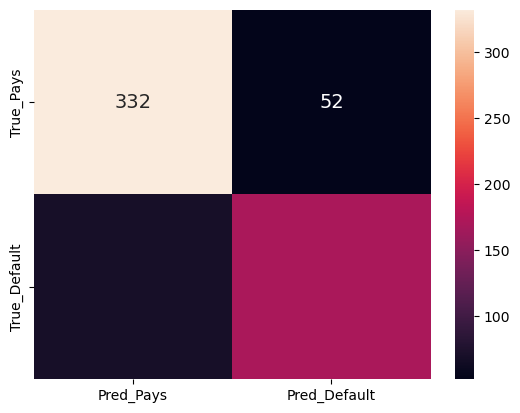

In [55]:
# Train
c_matrix = confusion_matrix(y_train, log_reg.predict(X_train)) 

c_matrix_df = pd.DataFrame(c_matrix, columns = ['Pred_Pays', 'Pred_Default'],
                          index = ['True_Pays', 'True_Default'])

sns.heatmap(c_matrix_df, annot=True, fmt='g');


In [56]:
# Train
print(classification_report(y_train, log_reg.predict(X_train)))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       384
           1       0.77      0.71      0.74       239

    accuracy                           0.81       623
   macro avg       0.80      0.79      0.79       623
weighted avg       0.80      0.81      0.80       623



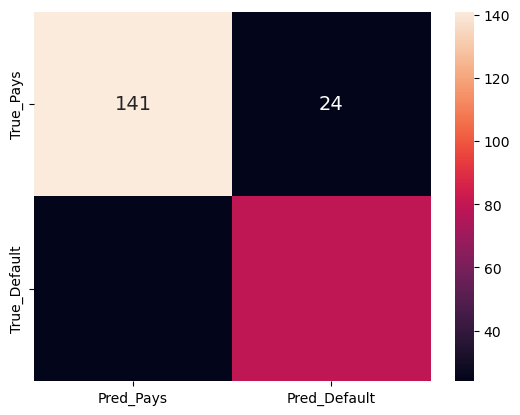

In [57]:
# Test
c_matrix = confusion_matrix(y_test, log_reg.predict(X_test)) 

c_matrix_df = pd.DataFrame(c_matrix, columns = ['Pred_Pays', 'Pred_Default'],
                          index = ['True_Pays', 'True_Default'])

sns.heatmap(c_matrix_df, annot=True, fmt='g');


In [58]:
# Test
print(classification_report(y_test, log_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       165
           1       0.77      0.77      0.77       103

    accuracy                           0.82       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268



### Sin variables con correlación más pequeña

In [59]:
log_reg.fit(X_train_sv, y_train_sv)

LogisticRegression(max_iter=5000)

#### Accuracy

In [60]:
acc_train = round(accuracy_score(log_reg.predict(X_train_sv), y_train_sv), 3)
acc_test = round(accuracy_score(log_reg.predict(X_test_sv), y_test_sv), 3)

print("Accuracy train:", acc_train)
print("Accuracy test:", acc_test)

Accuracy train: 0.782
Accuracy test: 0.795


Da un accuracy alto. Reviso las proporciones en las variables target para Train y Test

In [61]:
y_train_sv.value_counts(True)

survived
0    0.616372
1    0.383628
Name: proportion, dtype: float64

In [62]:
y_test_sv.value_counts(True)

survived
0    0.615672
1    0.384328
Name: proportion, dtype: float64

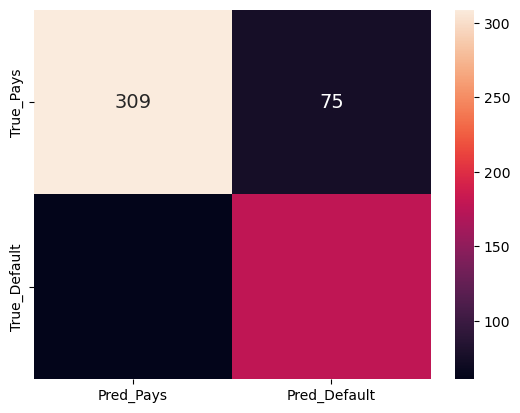

In [63]:
# Test
c_matrix = confusion_matrix(y_train_sv, log_reg.predict(X_train_sv)) 

c_matrix_df = pd.DataFrame(c_matrix, columns = ['Pred_Pays', 'Pred_Default'],
                          index = ['True_Pays', 'True_Default'])

sns.heatmap(c_matrix_df, annot=True, fmt='g');

In [64]:
# Train
print(classification_report(y_train_sv, log_reg.predict(X_train_sv)))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       384
           1       0.70      0.74      0.72       239

    accuracy                           0.78       623
   macro avg       0.77      0.77      0.77       623
weighted avg       0.78      0.78      0.78       623



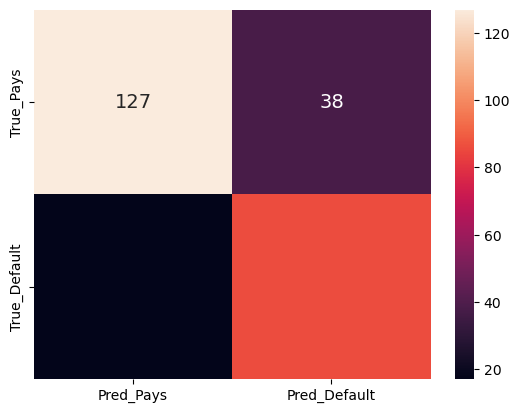

In [65]:
# Test
c_matrix = confusion_matrix(y_test_sv, log_reg.predict(X_test_sv)) 

c_matrix_df = pd.DataFrame(c_matrix, columns = ['Pred_Pays', 'Pred_Default'],
                          index = ['True_Pays', 'True_Default'])

sns.heatmap(c_matrix_df, annot=True, fmt='g');

In [66]:
# Test
print(classification_report(y_test_sv, log_reg.predict(X_test_sv)))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       165
           1       0.69      0.83      0.76       103

    accuracy                           0.79       268
   macro avg       0.79      0.80      0.79       268
weighted avg       0.81      0.79      0.80       268



### Sin variables que correlacionaban entre ellas

In [67]:
log_reg.fit(X_train_sc, y_train_sc)

LogisticRegression(max_iter=5000)

#### Accuracy

In [68]:
acc_train = round(accuracy_score(log_reg.predict(X_train_sc), y_train_sc), 3)
acc_test = round(accuracy_score(log_reg.predict(X_test_sc), y_test_sc), 3)

print("Accuracy train:", acc_train)
print("Accuracy test:", acc_test)

Accuracy train: 0.806
Accuracy test: 0.813


Da un accuracy alto. Reviso las proporciones en las variables target para Train y Test

In [69]:
y_train_sc.value_counts(True)

survived
0    0.616372
1    0.383628
Name: proportion, dtype: float64

In [70]:
y_test_sc.value_counts(True)

survived
0    0.615672
1    0.384328
Name: proportion, dtype: float64

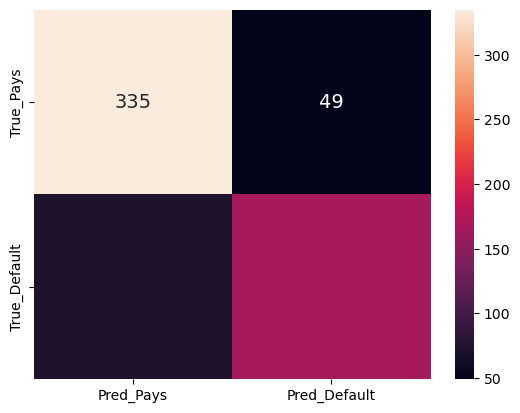

In [71]:
# Train
c_matrix = confusion_matrix(y_train_sc, log_reg.predict(X_train_sc)) 

c_matrix_df = pd.DataFrame(c_matrix, columns = ['Pred_Pays', 'Pred_Default'],
                          index = ['True_Pays', 'True_Default'])

sns.heatmap(c_matrix_df, annot=True, fmt='g');

In [72]:
# Train
print(classification_report(y_train_sc, log_reg.predict(X_train_sc)))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       384
           1       0.77      0.70      0.73       239

    accuracy                           0.81       623
   macro avg       0.80      0.79      0.79       623
weighted avg       0.80      0.81      0.80       623



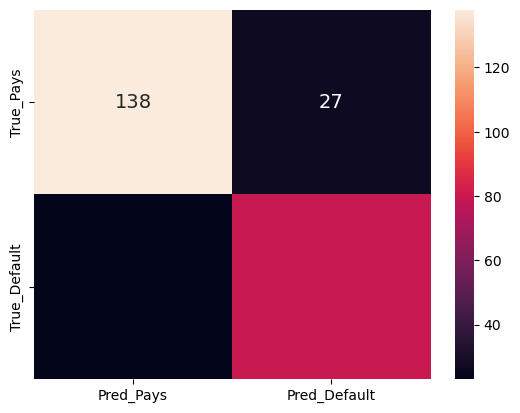

In [73]:
# Test
c_matrix = confusion_matrix(y_test_sc, log_reg.predict(X_test_sc)) 

c_matrix_df = pd.DataFrame(c_matrix, columns = ['Pred_Pays', 'Pred_Default'],
                          index = ['True_Pays', 'True_Default'])

sns.heatmap(c_matrix_df, annot=True, fmt='g');

In [74]:
# Test
print(classification_report(y_test_sc, log_reg.predict(X_test_sc)))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       165
           1       0.75      0.78      0.76       103

    accuracy                           0.81       268
   macro avg       0.80      0.81      0.80       268
weighted avg       0.82      0.81      0.81       268



**Reflexión con los conocimientos que tengo actualmente (y DUDAS a partes iguales):** 
Para una relación de `supervivientes`del 38% aprox. y de `fallecidos` del 62% prox:
- Con todas las variables:
    - Accuracy train: 0.806
    - Accuracy test: 0.821
- Sin variables con menor correlación con variable target:
    - Accuracy train: 0.782
    - Accuracy test: 0.795
- Sin variables que correlacionaban más entre ellas:
    - Accuracy train: 0.806
    - Accuracy test: 0.813

¿Cuál sería el mejor modelo????? ¿Qué crierios seguir????

## 11. Probabilidad supervivencia
EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.

In [75]:
df_titanic = pd.read_csv("./data/titanic.csv")

In [76]:
edad = (df_titanic['age'] >= 30) & (df_titanic['age'] <= 40)
sexo = (df_titanic['sex'] == 'male')
embarque = (df_titanic['embark_town'] == 'Southampton')
billete = (df_titanic['fare'] == 0)
clase = (df_titanic['pclass'] == 2)
supervivencia = (df_titanic['alive'] == 'yes')

# Probabilidad de que se cumplan todas las condiciones dado que el pasajero sobrevivió
condiciones_dado_sobrevivencia = edad & sexo & embarque & billete & clase & supervivencia
probabilidad_condiciones_dado_sobrevivencia = len(df_titanic[condiciones_dado_sobrevivencia]) / len(df_titanic[supervivencia])

# Probabilidad de supervivencia en general
probabilidad_sobrevivencia = len(df_titanic[supervivencia]) / len(df_titanic)

# Probabilidad de que se cumplan todas las condiciones independientemente de la supervivencia
probabilidad_condiciones = len(df_titanic[edad & sexo & embarque & billete & clase]) / len(df_titanic)

# Probabilidad condicional de supervivencia dado que se cumplen todas las condiciones
probabilidad_condicional_sobrevivencia = (probabilidad_condiciones_dado_sobrevivencia * probabilidad_sobrevivencia) / probabilidad_condiciones

probabilidad_condicional_sobrevivencia

ZeroDivisionError: float division by zero

## 12. Cambio target
EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.  

Yo no lo veo tan simple como cambiar el target y listo.... No hay tiempo para más...